In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, glob

In [2]:
def plot_corr(data, figsize=(15,15)):
    '''
    Plot correlation 
    Args:
    - data: pd dataframe
    '''
    corr = data.corr()
    sns.set(font_scale=1.2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', center=0, annot=True,
                        annot_kws={'fontsize':8})

In [3]:
path = os.path.join(os.path.dirname(os.getcwd()), '../Data/Extracted_data/')
os.chdir(path)

### Fracture toughness

In [4]:
FT = pd.read_csv('fracture_toughness.csv')
FT.set_index('ID', inplace=True)
FT.drop(['Type', 'Percent_cold_work','KIC_stress_intensity_max_ksi_x_in1_2', 'KIC_stress_intensity_range_ksi_x_in1_2', 'JQ_lb-in_in2'], axis=1, inplace=True)
FT.rename(columns={'KJIC_ksi_x_in1_2':'KJIC'}, inplace=True)

### TEP (both)

In [5]:
TEP = pd.read_csv('TEP_magnetic_susceptibility_summary.csv')
TEP.set_index('ID', inplace=True)
TEP.drop(['material', 'cold_work_percent'], axis=1, inplace=True)
TEP.rename(columns={'magnetic_susceptibility_average':'MS_Avg', 'magnetic_susceptibility_neg_error': 'MS_neg_error',
                   'magnetic_susceptibility_pos_error':'MS_pos_error'}, inplace=True)

### Nonlinear

In [6]:
UT_NL = pd.read_csv('UT_nonlinear.csv')
UT_NL.drop(['material', 'cold_work_percent','A2/A1^2', 'Thickness (mm)', 'R^2'], axis=1, inplace=True)
UT_NL.set_index('ID', inplace=True)
UT_NL = UT_NL.groupby('ID').mean().add_suffix('_avg')

### Internal Friction 225MHz

In [7]:
IF_225_dfs=[]
for file in glob.glob('*friction*25MHz.csv'):
    df = pd.read_csv(file)
    IF_225_dfs.append(df)

UT_IF_225 = pd.concat(IF_225_dfs, axis=0, ignore_index=False)
UT_IF_225['Sample ID'] = UT_IF_225['Sample ID'].str.replace('%|CW|\,', '').str.strip().str.replace(' - ', '-')\
.str.replace('  ', ' ').str.replace(' ', '-').str.strip('-1')+ '-1'
UT_IF_225.drop(['% CW'], axis=1, inplace=True)
UT_IF_225.rename(columns={'Sample ID':'ID', '% change from 0% CW':'PC_IF',
                         	'Standard Error': 'SE_IF', 'Standard Error (%)': 'SE_%_IF'}, inplace=True)
UT_IF_225.set_index('ID', inplace=True)
UT_IF_225 = UT_IF_225.add_suffix('_2.25MHz')
UT_IF_225.replace(regex={'%':''}, inplace=True)
UT_IF_225 = UT_IF_225.astype('float')
UT_IF_225['IF_2.25MHz'] = UT_IF_225['SE_IF_2.25MHz']/UT_IF_225['SE_%_IF_2.25MHz']*100

<AxesSubplot:xlabel='ID'>

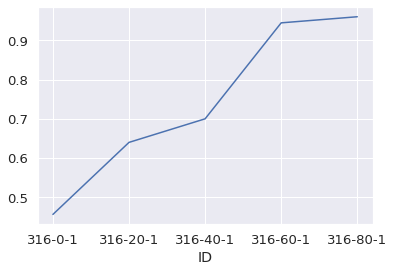

In [60]:
UT_IF_225.iloc[15:20,3].plot()

### Internal Friction 35MHz

In [8]:
IF_35_dfs=[]
for file in glob.glob('*friction*_5MHz.csv'):
    df = pd.read_csv(file)
    IF_35_dfs.append(df)

UT_IF_35 = pd.concat(IF_35_dfs, axis=0, ignore_index=False)
UT_IF_35['Sample ID'] = UT_IF_35['Sample ID'].str.replace('%|CW|\,', '').str.strip().str.replace(' - ', '-')\
.str.replace('  ', ' ').str.replace(' ', '-').str.strip('-1')+ '-1'
UT_IF_35.drop(['% CW'], axis=1, inplace=True)
UT_IF_35.rename(columns={'Sample ID':'ID', '% change from 0% CW':'PC_IF',
                         	'Standard Error': 'SE_IF', 'Standard Error (%)': 'SE_%_IF'}, inplace=True)
UT_IF_35.set_index('ID', inplace=True)
UT_IF_35 = UT_IF_35.add_suffix('_3.5MHz')
UT_IF_35.replace(regex={'%':''}, inplace=True)
UT_IF_35 = UT_IF_35.astype('float')
UT_IF_35['IF_3.5MHz'] = UT_IF_35['SE_IF_3.5MHz']/UT_IF_35['SE_%_IF_3.5MHz']*100

### Backscattering

In [9]:
UT_BS = pd.read_csv('UT_backscattering.csv')

UT_BS['Sample ID'] = UT_BS['Sample ID'].str.replace('%|CW|\,', '').str.strip().str.replace(' - ', '-')\
.str.replace('  ', ' ').str.replace(' ', '-').str.strip('-1')+ '-1'
UT_BS.rename(columns={'Sample ID':'ID', '% change from 0% CW': 'PC_BS'}, inplace=True)
UT_BS.set_index('ID', inplace=True)
UT_BS.replace(regex={'%':''}, inplace=True)
UT_BS = UT_BS.astype('float')

Merge all data

In [62]:
merged = FT.join([TEP, UT_NL, UT_IF_225, UT_IF_35, UT_BS], how='left')

In [63]:
merged.to_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'))

### Plotting

group data by type of sample and cold work

In [64]:
merged.index = merged.index.str.rstrip('-12345')

In [65]:
mean_df = merged.groupby('ID').mean()

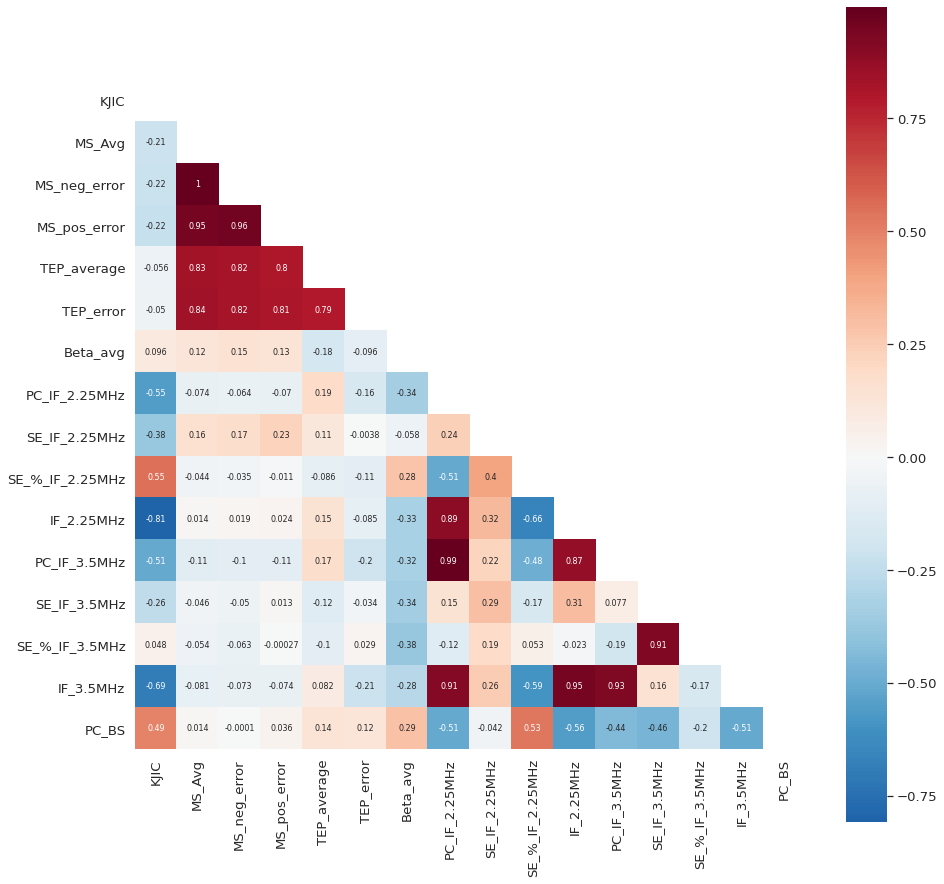

In [66]:
plot_corr(mean_df)

### Use only mean

In [67]:
short_mean = mean_df.loc[:, ['KJIC', 'MS_Avg', 'TEP_average',
        'Beta_avg', 'IF_2.25MHz', 'IF_3.5MHz',
       'PC_BS']]
short_mean['Type'] = short_mean.index.str.split('-').str[0]
short_mean

,KJIC,MS_Avg,TEP_average,Beta_avg,IF_2.25MHz,IF_3.5MHz,PC_BS,Type
ID,,,,,,,,
304-0,162.000000,0.12000,-1.54700,0.002743,0.448276,0.384615,0.0,304
304-20,105.780000,0.49600,-1.32200,0.002093,0.700000,0.545455,-12.0,304
304-40,100.700000,1.35000,-1.21600,0.001941,0.733333,0.631579,-20.0,304
304-60,91.320000,1.37100,-1.24900,0.002567,0.909091,0.882353,3.0,304
304-80,73.775000,3.96600,-0.97600,0.002420,0.888889,0.875000,10.0,304
316-0,111.240000,0.03900,-1.50600,0.002433,0.456522,0.416667,0.0,316
316-20,69.960000,0.03600,-1.57300,0.002785,0.640000,0.571429,30.0,316
316-40,68.220000,0.04400,-1.64000,0.002494,0.700000,0.625000,-34.0,316
316-60,69.000000,0.04925,-1.67375,0.002292,0.944444,1.300000,-57.0,316


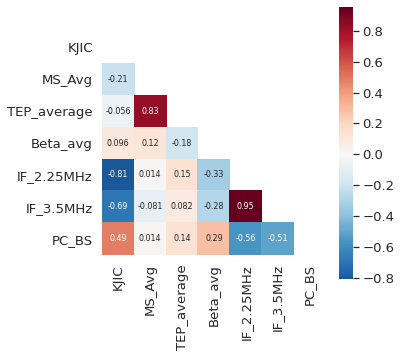

In [68]:
plot_corr(short_mean, figsize=(5,5))

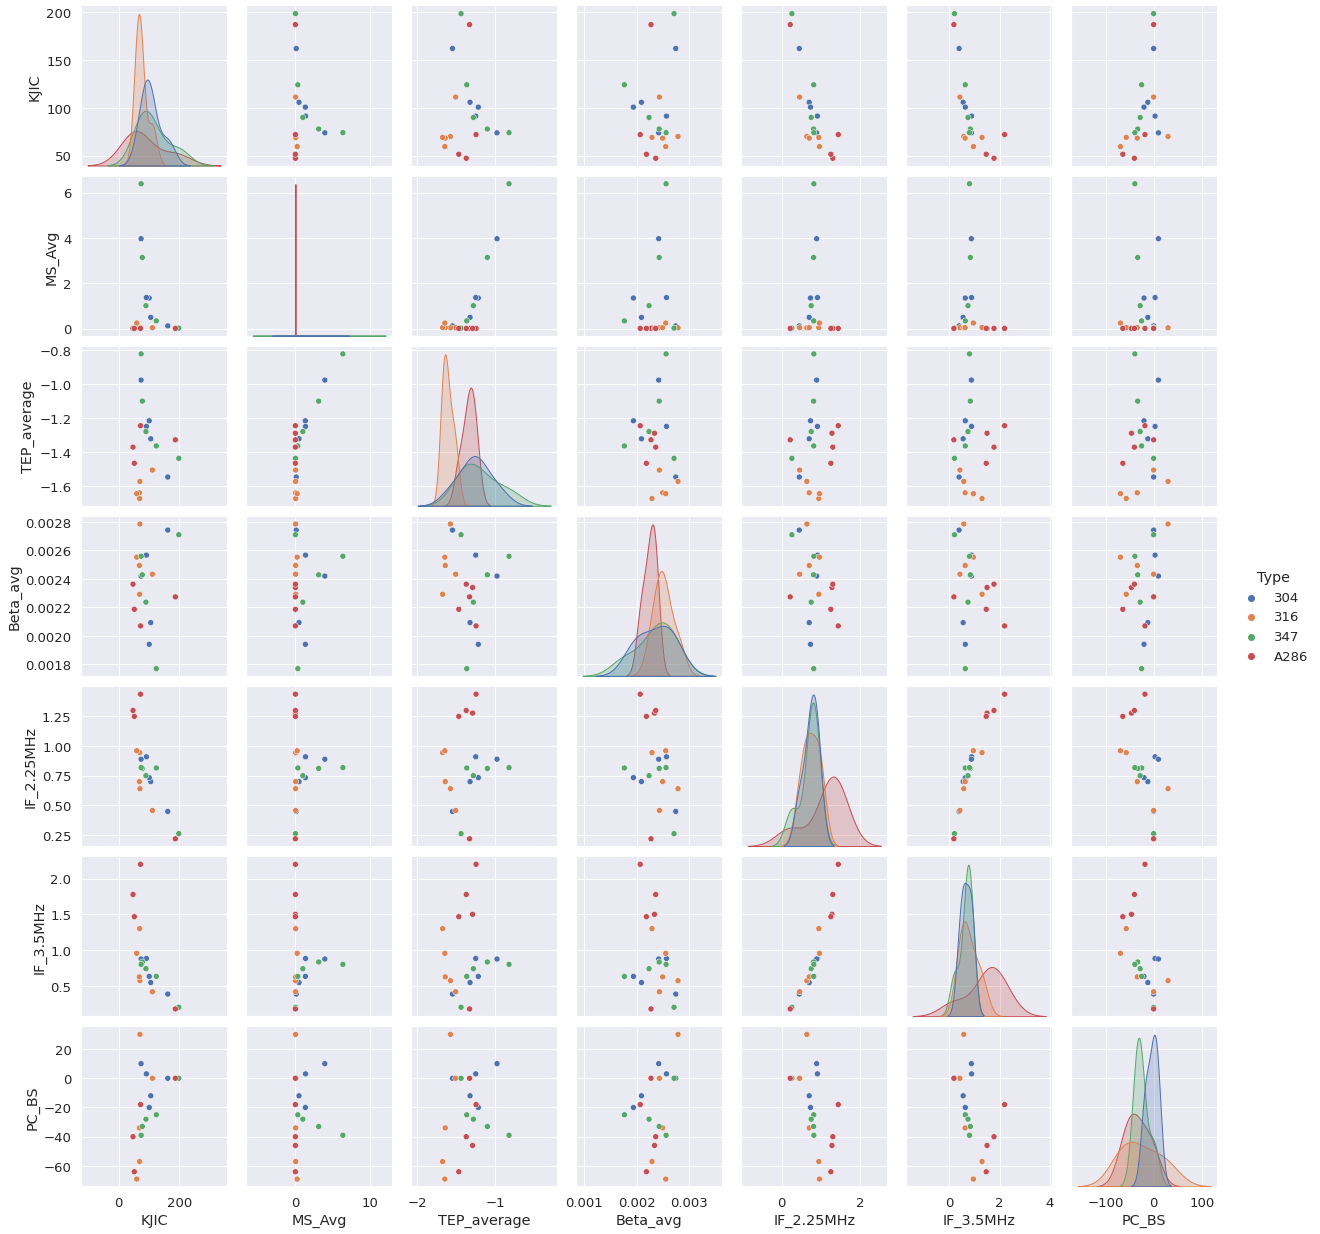

In [69]:
sns.pairplot(short_mean, hue='Type')

In [86]:
short_mean.head()

,KJIC,MS_Avg,TEP_average,Beta_avg,IF_2.25MHz,IF_3.5MHz,PC_BS,Type
ID,,,,,,,,
304-0,162.000,0.120,-1.547,0.002743,0.448276,0.384615,0.0,304
304-20,105.780,0.496,-1.322,0.002093,0.700000,0.545455,-12.0,304
304-40,100.700,1.350,-1.216,0.001941,0.733333,0.631579,-20.0,304
304-60,91.320,1.371,-1.249,0.002567,0.909091,0.882353,3.0,304
304-80,73.775,3.966,-0.976,0.002420,0.888889,0.875000,10.0,304


In [93]:
test = pd.melt(short_mean, id_vars=['KJIC', 'Type'], value_vars=['MS_Avg', 'TEP_average', 'Beta_avg', 'IF_2.25MHz', 'IF_3.5MHz', 'PC_BS'] )

In [94]:
test

,KJIC,Type,variable,value
0,162.000000,304,MS_Avg,0.120
1,105.780000,304,MS_Avg,0.496
2,100.700000,304,MS_Avg,1.350
3,91.320000,304,MS_Avg,1.371
4,73.775000,304,MS_Avg,3.966
...,...,...,...,...
115,187.025000,A286,PC_BS,0.000
116,71.950000,A286,PC_BS,-18.000
117,NaN,A286,PC_BS,-46.000
118,47.166667,A286,PC_BS,-40.000


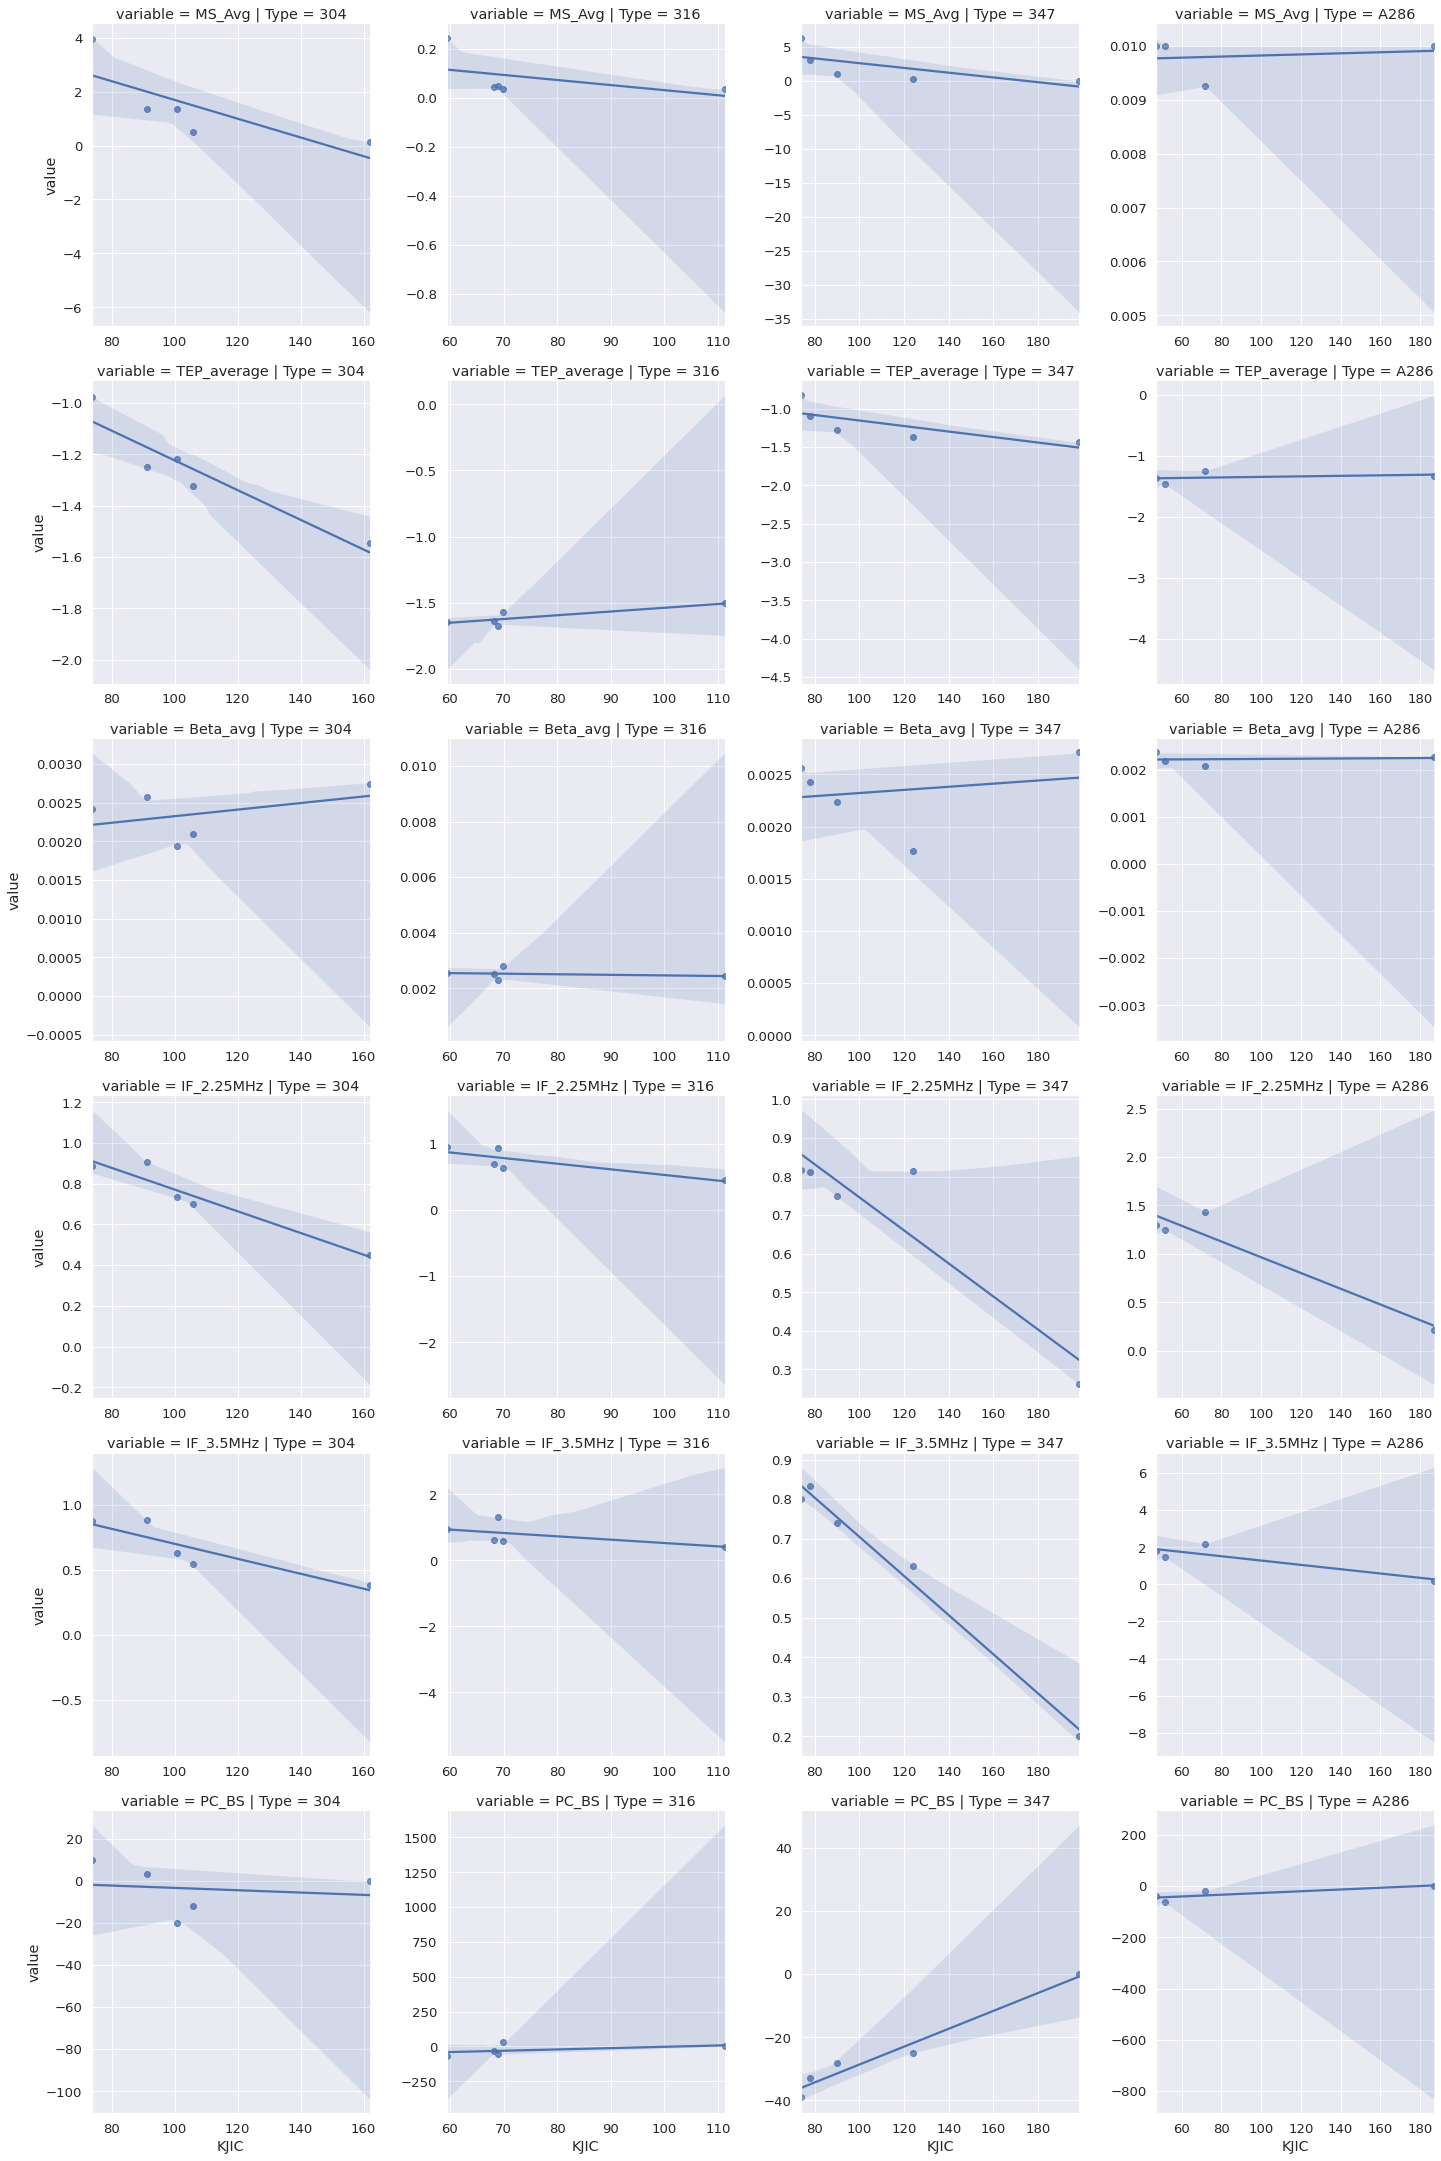

In [99]:
sns.lmplot(x='KJIC', y='value', data=test, col='Type', row='variable', sharey=False, sharex=False)